In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score

In [6]:
class KClustering:
    
    def __init__(self, num_clusters, stop_criteria="no_change") -> None:
        self.stop_criteria = stop_criteria
        self.num_clusters = num_clusters
        self.centroids = None
        self.sse_score = None
        self.last_sse_score = -1 ## squares cannot be negative, just taking a negative number
        self.iterations = 0
        
    def get_sse(self):
        return self.sse_score
    
    def get_total_iterations(self):
        return self.iterations
    
    def euclidean_distance(self, point, centroids):
        return np.sqrt(np.sum((centroids - point)**2, axis=1))

    def sum_of_sse(self, centroids, data, cluster_assignments):
        error_sum = 0
        for idx, d in enumerate(data):
            error_sum += np.sum((centroids[cluster_assignments[idx]] - d) ** 2)
        return error_sum

    
    
    def fit(self, X, max_iterations=500):
        # Initializing centroids randomly
        self.centroids = np.random.uniform(
            low=np.amin(X, axis=0),
            high=np.amax(X, axis=0),
            size=(self.num_clusters, X.shape[1]))

        for _ in range(max_iterations):
            # Assigning 
            cluster_assignments = []
            for point in X:
                distances = self.euclidean_distance(point,centroids=self.centroids)
                cluster_num = np.argmin(distances)
                cluster_assignments.append(cluster_num)

            cluster_assignments = np.asarray(cluster_assignments)

            # Calculating new centroids based on assigned clusters
            cluster_indices = []
            for idx in range(self.num_clusters):
                cluster_indices.append(np.argwhere(cluster_assignments == idx))

            new_centroids = []
            for i, indices in enumerate(cluster_indices):
                if len(indices) == 0:
                    new_centroids.append(self.centroids[i])
                else:
                    new_centroids.append(np.mean(X[indices], axis=0)[0])

            # Stopping criteria
            if self.stop_criteria == "no_change" and np.max(self.centroids - np.array(new_centroids)) < 1e-2:
                break
            elif self.stop_criteria == "increase_sse":
                current_sse = self.sum_of_sse(X, np.array(new_centroids), cluster_assignments)
                if current_sse > self.last_sse_score:
                    break
                self.last_sse_score = current_sse
            else:
                self.centroids = np.array(new_centroids)
            
            self.iterations += 1

        # Calculate the final SSE after performing K-means
        self.sse_score = self.sum_of_sse(X, self.centroids, cluster_assignments)
        
        return cluster_assignments


In [7]:
dataset = np.array(pd.read_csv(r'C:\\Users\\Yash\\jupyter\\Data Mining\\hw3\\kmeans_data\\data.csv', header=None))
labels = np.ravel(pd.read_csv(r'C:\\Users\\Yash\\jupyter\\Data Mining\\hw3\\kmeans_data\\label.csv', header=None))

In [8]:
dataset.shape

(10000, 784)

In [9]:
no_of_classes = np.unique(labels)
no_of_clusters = no_of_classes.size
total_iters = 100
kmeans_euclid = KClustering(num_clusters=no_of_clusters)
##fitting

kmeans_model = kmeans_euclid.fit(X=dataset, max_iterations= total_iters)

## Distance model training and SSE Scores 

### SSE eucledian

In [12]:
np.unique(kmeans_model)
sse_euclid = kmeans_euclid.get_sse()
sse_euclid

43726406.20834501

### SSE cosine

In [97]:
cos_dis = pairwise_distances(dataset, metric='cosine')
cos_dis_kmeans = KClustering(num_clusters=no_of_clusters)
cos_dis_kmeans_model = cos_dis_kmeans.fit(cos_dis, max_iterations=total_iters)

In [98]:
np.unique(cos_dis_kmeans_model)
sse_cosine = cos_dis_kmeans.get_sse()
sse_cosine

4476.190850191341

### SSE Jarcard

In [17]:
jaccard_dis = pairwise_distances(dataset, metric='hamming')
jaccard_kmeans = KClustering(num_clusters=no_of_clusters)
## fitting 
jaccard_kmeans_results = jaccard_kmeans.fit(X=jaccard_dis, max_iterations=total_iters)

In [18]:
see_jaccard = jaccard_kmeans.get_sse()
see_jaccard

1007.8569085334295

## Part 2

In [102]:

def generate_cluster_labels(clusters, true_labels):

    unique_classes = np.unique(true_labels)
    predicted_labels = np.zeros(len(clusters))
    
    for cluster_id in range(len(np.unique(clusters))):

        indices = np.flatnonzero(clusters == cluster_id)
        cluster_true_labels = true_labels[indices]
        votes = [np.count_nonzero(cluster_true_labels == cls) for cls in unique_classes]

        max_label = np.argmax(votes)
        predicted_labels[indices] = unique_classes[max_label]
        
    return predicted_labels

In [104]:
labels_euclid = generate_cluster_labels(kmeans_model, labels)
labels_cosine = generate_cluster_labels(cos_dis_kmeans_model, labels)
labels_jaccard = generate_cluster_labels(jaccard_kmeans_results, labels)

In [106]:
# Compute predictive accuracy
accuracy_euclid = accuracy_score(labels, labels_euclid)
accuracy_cosine = accuracy_score(labels, labels_cosine)
accuracy_jaccard = accuracy_score(labels, labels_jaccard)

In [108]:
accuracy_euclid,accuracy_cosine,accuracy_jaccard ## Euclid Better

(0.6059, 0.3331, 0.1699)

#### Part 3

In [25]:
euclidean_iters = kmeans_euclid.get_total_iterations()
cosine_iters = cos_dis_kmeans.get_total_iterations()
jarcard_iters = jaccard_kmeans.get_total_iterations()

In [26]:
euclidean_iters, cosine_iters, jarcard_iters ## euclid takes most iterations to converge

(42, 10, 3)

## Part 4

(a) no change in centroid position

In [29]:
kmeans_euclid2 = KClustering(num_clusters=no_of_clusters)

euclidean_kmeans_prediction = kmeans_euclid2.fit(dataset, max_iterations=total_iters)

sse_euclid_sum = kmeans_euclid2.get_sse()

In [30]:
sse_euclid_sum

40562073.565572545

In [31]:
kmeans_cosine2 = KClustering(num_clusters=no_of_clusters)
cosine_kmeans_prediction = kmeans_cosine2.fit(cos_dis, max_iterations=total_iters)
sse_cosine_kmeans = kmeans_cosine2.get_sse()


In [32]:
sse_cosine_kmeans

3444.1059173336926

In [33]:
jaccard_kmeans2 = KClustering(num_clusters=no_of_clusters)
jaccard_kmeans_prediction = jaccard_kmeans2.fit(jaccard_dis, max_iterations=total_iters)
sse_jaccard_kmeans = jaccard_kmeans2.get_sse()

In [34]:
sse_jaccard_kmeans = jaccard_kmeans2.get_sse()
sse_jaccard_kmeans

1385.8271978591379

##### (b) Increase Criteria

In [36]:
euclidean_kmeans3 = KClustering(num_clusters=no_of_clusters, stop_criteria="increase_sse")
euclidean_kmeans_prediction = euclidean_kmeans3.fit(dataset, max_iterations=total_iters)
sse_euclidean_kmeans3 = euclidean_kmeans3.get_sse()


In [37]:
sse_euclidean_kmeans3

125919280.34025426

In [38]:
kmeans_cosine3 = KClustering(num_clusters=no_of_clusters, stop_criteria="increase_sse")
cosine_kmeans_prediction = kmeans_cosine3.fit(cos_dis, max_iterations=total_iters)
sse_cosine_kmeans_increase_sse = kmeans_cosine3.get_sse()

In [39]:
sse_cosine_kmeans_increase_sse

11234.808459731195

In [40]:
jaccard_kmeans3 = KClustering(num_clusters=no_of_clusters, stop_criteria="increase_sse")
jaccard_kmeans_prediction = jaccard_kmeans3.fit(jaccard_dis, max_iterations=total_iters)
sse_jaccard_kmeans_increase_sse = jaccard_kmeans3.get_sse()

In [41]:
sse_jaccard_kmeans_increase_sse

2069.9313308229252

##### (c) for max iterations

In [43]:
euclidean_kmeans4 = KClustering(num_clusters=no_of_clusters, stop_criteria="max_iterations")
euclidean_kmeans_prediction = euclidean_kmeans4.fit(dataset, max_iterations=total_iters)
sse_euclidean_kmeans_max_iter = euclidean_kmeans4.get_sse()

In [44]:
sse_euclidean_kmeans_max_iter

49050935.04678958

In [45]:
kmeans_cosine3 = KClustering(num_clusters=no_of_clusters, stop_criteria="max_iterations")
cosine_kmeans_prediction = kmeans_cosine3.fit(cos_dis, max_iterations=total_iters)
sse_cosine_kmeans_max_iter = kmeans_cosine3.get_sse()

In [46]:
sse_cosine_kmeans_max_iter 

1875.255911886788

In [47]:
jaccard_kmeans3 = KClustering(num_clusters=no_of_clusters, stop_criteria="max_iterations")
jaccard_kmeans_prediction = jaccard_kmeans3.fit(jaccard_dis, max_iterations=total_iters)
sse_jaccard_kmeans_max_iter = jaccard_kmeans3.get_sse()

In [48]:
sse_jaccard_kmeans_max_iter

1631.146425318516


## Task 2: Recommender Systems with Matrix Data

This section focuses on building and analyzing a recommender system using collaborative filtering methods and matrix factorization.


In [50]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Import necessary libraries
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

# File path to the dataset
ratings_file = 'C:\\Users\\Yash\\jupyter\\Data Mining\\hw3\\kmeans_data\\ratings_small.csv'

# a. Load data
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(ratings_file, reader=reader)

# Algorithms to evaluate
algorithms = {
    "User-Based CF": KNNBasic(sim_options={'user_based': True}),
    "Item-Based CF": KNNBasic(sim_options={'user_based': False}),
    "PMF (SVD)": SVD()
}


In [118]:
# c. Compute RMSE and MAE for each algorithm (5-fold CV)
results = {}
for name, algo in algorithms.items():
    results[name] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# d. Display mean performances
print("\nPerformance Comparison:")
for name, metrics in results.items():
    print(f"{name} - Average RMSE: {np.mean(metrics['test_rmse']):.4f}, Average MAE: {np.mean(metrics['test_mae']):.4f}")




Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9728  0.9637  0.9732  0.9667  0.9553  0.9663  0.0066  
MAE (testset)     0.7474  0.7394  0.7501  0.7414  0.7371  0.7431  0.0049  
Fit time          0.30    0.26    0.26    0.25    0.16    0.24    0.05    
Test time         1.50    1.40    1.55    1.06    1.07    1.32    0.21    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

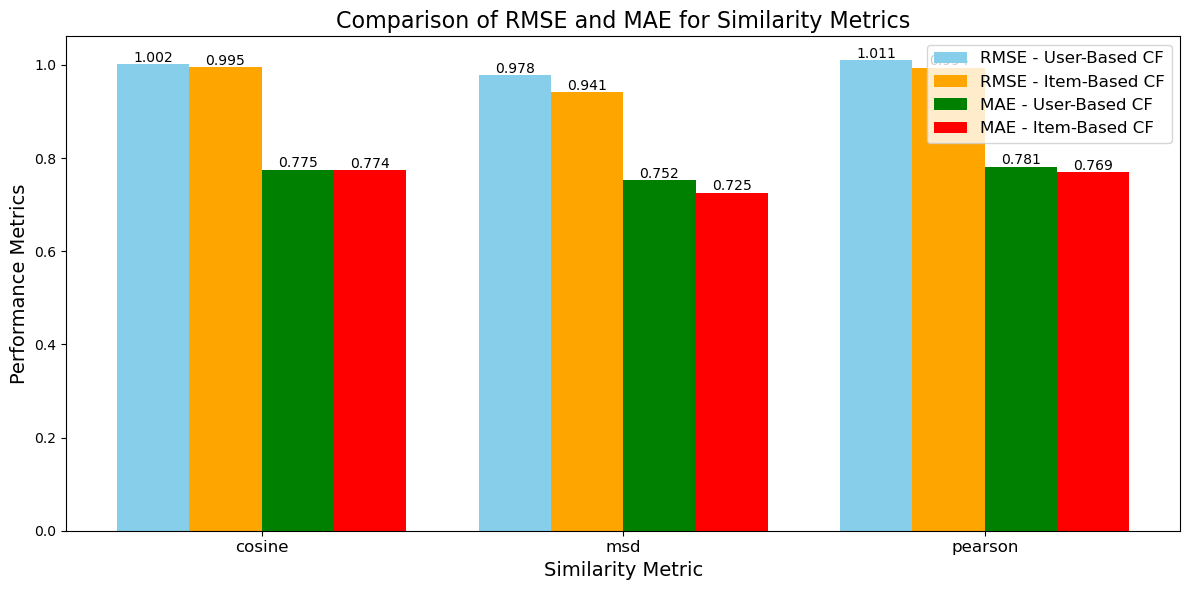

In [122]:
# f. COmparison of RMSE  
# Define similarity metrics
similarity_metrics = ['cosine', 'msd', 'pearson']

# Initialize storage for performance metrics
performance_rmse_user = []
performance_mae_user = []
performance_rmse_item = []
performance_mae_item = []

# Compute and store RMSE and MAE for each similarity metric
for sim_metric in similarity_metrics:
    # User-Based CF
    user_cf = KNNBasic(sim_options={'name': sim_metric, 'user_based': True})
    user_result = cross_validate(user_cf, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    performance_rmse_user.append(np.mean(user_result['test_rmse']))
    performance_mae_user.append(np.mean(user_result['test_mae']))
    
    # Item-Based CF
    item_cf = KNNBasic(sim_options={'name': sim_metric, 'user_based': False})
    item_result = cross_validate(item_cf, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    performance_rmse_item.append(np.mean(item_result['test_rmse']))
    performance_mae_item.append(np.mean(item_result['test_mae']))

# Print RMSE and MAE for each similarity metric
print("\nPerformance Metrics (User-Based CF):")
for metric, rmse, mae in zip(similarity_metrics, performance_rmse_user, performance_mae_user):
    print(f"{metric.capitalize()} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("\nPerformance Metrics (Item-Based CF):")
for metric, rmse, mae in zip(similarity_metrics, performance_rmse_item, performance_mae_item):
    print(f"{metric.capitalize()} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Plot RMSE and MAE for both methods
x = np.arange(len(similarity_metrics))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))

# RMSE bars
bars_rmse_user = ax.bar(x - 1.5 * width, performance_rmse_user, width, label='RMSE - User-Based CF', color='skyblue')
bars_rmse_item = ax.bar(x - 0.5 * width, performance_rmse_item, width, label='RMSE - Item-Based CF', color='orange')

# MAE bars
bars_mae_user = ax.bar(x + 0.5 * width, performance_mae_user, width, label='MAE - User-Based CF', color='green')
bars_mae_item = ax.bar(x + 1.5 * width, performance_mae_item, width, label='MAE - Item-Based CF', color='red')

# Add labels, title, and legend
ax.set_xlabel('Similarity Metric', fontsize=14)
ax.set_ylabel('Performance Metrics', fontsize=14)
ax.set_title('Comparison of RMSE and MAE for Similarity Metrics', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(similarity_metrics, fontsize=12)
ax.legend(fontsize=12)

# Annotate bar heights
for bar in bars_rmse_user + bars_rmse_item + bars_mae_user + bars_mae_item:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{bar.get_height():.3f}', 
            ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

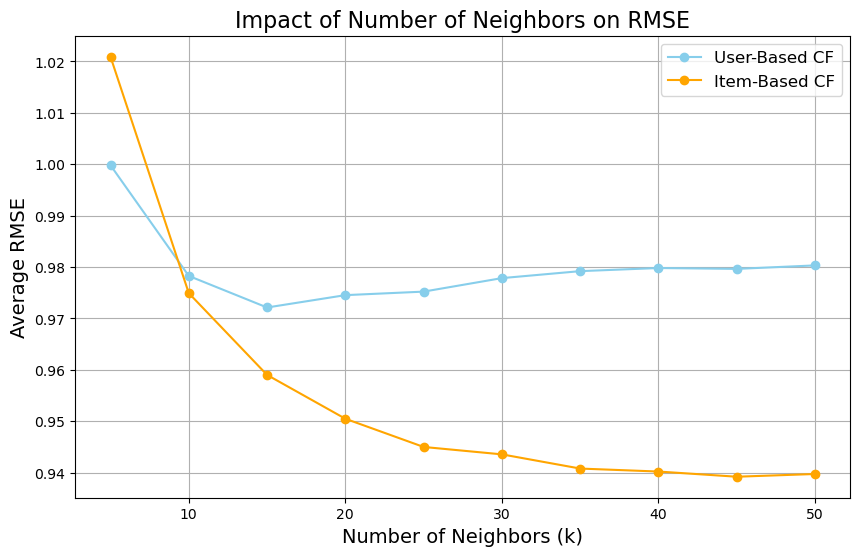


Best number of neighbors for User-Based CF: 15
Best number of neighbors for Item-Based CF: 45


In [53]:
# f. Analyze impact of number of neighbors
neighbors = range(5, 51, 5)
rmse_user = []
rmse_item = []

for k in neighbors:
    user_cf = KNNBasic(k=k, sim_options={'user_based': True})
    item_cf = KNNBasic(k=k, sim_options={'user_based': False})
    
    user_result = cross_validate(user_cf, data, measures=['RMSE'], cv=3, verbose=False)
    item_result = cross_validate(item_cf, data, measures=['RMSE'], cv=3, verbose=False)
    
    rmse_user.append(np.mean(user_result['test_rmse']))
    rmse_item.append(np.mean(item_result['test_rmse']))

# Plot neighbor impact
plt.figure(figsize=(10, 6))
plt.plot(neighbors, rmse_user, label='User-Based CF', marker='o', color='skyblue')
plt.plot(neighbors, rmse_item, label='Item-Based CF', marker='o', color='orange')
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Average RMSE', fontsize=14)
plt.title('Impact of Number of Neighbors on RMSE', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# g. Find optimal number of neighbors
best_k_user = neighbors[np.argmin(rmse_user)]
best_k_item = neighbors[np.argmin(rmse_item)]

print(f"\nBest number of neighbors for User-Based CF: {best_k_user}")
print(f"Best number of neighbors for Item-Based CF: {best_k_item}")
